# Parsed the files that contain the retrieved nodes for the different methods and prepares them to be anotated by chatgpt

In [312]:
sorted_path = 'Retrieved Nodes Original/full_sorted_k4_d6/'
unsorted_path = 'Retrieved Nodes Original/full_unsorted_k4_d6'




In [313]:
import os
import re

def parse_files_in_directory(directory_path):
    parsed_data_list = []
    triplet_pattern = re.compile(r'\[(.*?)\]: (.*?) --\[(.*?)\]-> (.*?) ([0-9.]+)')

    # Get all filenames in the directory
    filenames = [f for f in os.listdir(directory_path) if os.path.isfile(os.path.join(directory_path, f))]

    # Filter filenames that match the pattern 'n.txt' where n is an integer
    file_pattern = re.compile(r'(\d+)\.txt$')
    numbered_files = []
    for f in filenames:
        match = file_pattern.match(f)
        if match:
            number = int(match.group(1))
            numbered_files.append((number, f))

    # Sort the files based on the extracted number
    numbered_files.sort(key=lambda x: x[0])

    # Process files in the sorted order
    for number, filename in numbered_files:
        filepath = os.path.join(directory_path, filename)

        # Try reading the file with UTF-8 encoding
        try:
            with open(filepath, 'r', encoding='utf-8') as file:
                lines = [line.strip() for line in file if line.strip()]
        except UnicodeDecodeError:
            # Fall back to Latin-1 encoding if UTF-8 fails
            with open(filepath, 'r', encoding='latin-1') as file:
                lines = [line.strip() for line in file if line.strip()]
        except Exception as e:
            print(f"Error reading file {filename}: {e}")
            continue

        if not lines:
            continue

        iterator = iter(lines)
        data = {'question': None, 'seeds': [], 'triplets': []}

        try:
            # Extract the question
            data['question'] = next(iterator)

            # Skip the 'None' line if it exists
            current_line = next(iterator)
            if current_line.lower() == 'none':
                pass
            else:
                # If 'None' line is missing, we need to process the current line
                if current_line.startswith('Seed:'):
                    data['seeds'].append(current_line[len('Seed:'):].strip())
                else:
                    # If the line is not a seed, reset the iterator
                    iterator = iter([current_line] + list(iterator))

            # Extract seed nodes
            for line in iterator:
                if line.startswith('Seed:'):
                    data['seeds'].append(line[len('Seed:'):].strip())
                else:
                    # Break if the line doesn't start with 'Seed:'
                    break

            # Extract triplets
            for line in iterator:
                match = triplet_pattern.match(line)
                if match:
                    data['triplets'].append({
                        'seed': match.group(1),
                        'head': match.group(2),
                        'relation': match.group(3),
                        'tail': match.group(4),
                        'score': float(match.group(5))
                    })
        except StopIteration:
            pass  # Handle files that may not have complete content

        parsed_data_list.append(data)

    return parsed_data_list


In [314]:
parsed_sorted_data = parse_files_in_directory(sorted_path)
parsed_unsorted_data = parse_files_in_directory(unsorted_path)

In [315]:
def create_clean_entry(entry):
    clean_entry = {'question': entry['question'], 'triplets': []}
    seen_triplets = set()

    for triplet in entry.get('triplets', []):
        # Create a tuple of (head, relation, tail) to identify duplicates
        triplet_key = (triplet['head'], triplet['relation'], triplet['tail'])

        if triplet_key not in seen_triplets:
            seen_triplets.add(triplet_key)
            # Exclude the 'seed' key, and create an 'id' from head-relation-tail
            clean_triplet = {
                'head': triplet['head'],
                'relation': triplet['relation'],
                'tail': triplet['tail'],
                'score': triplet['score'],
                'id': f"{triplet['head']}-{triplet['relation']}-{triplet['tail']}"
            }
            clean_entry['triplets'].append(clean_triplet)

    return clean_entry

# Example usage
clean_sorted_data = [create_clean_entry(entry) for entry in parsed_sorted_data]
clean_unsorted_data = [create_clean_entry(entry) for entry in parsed_unsorted_data]


In [316]:
def combine_clean_entries(clean_sorted_data, clean_unsorted_data):
    combined_data = []
    
    # Assuming that clean_sorted_data and clean_unsorted_data have the same length
    # and that entries correspond to the same question
    for sorted_entry, unsorted_entry in zip(clean_sorted_data, clean_unsorted_data):
        combined_entry = {'question': sorted_entry['question'], 'triplets': []}
        seen_triplets = set()
        
        # First, add triplets from sorted_entry
        for triplet in sorted_entry.get('triplets', []):
            triplet_id = triplet['id']
            if triplet_id not in seen_triplets:
                seen_triplets.add(triplet_id)
                
                # Copy the triplet without the 'score' field
                new_triplet = {key: value for key, value in triplet.items() if key != 'score'}
                combined_entry['triplets'].append(new_triplet)
        
        # Then, add triplets from unsorted_entry, if not already added
        for triplet in unsorted_entry.get('triplets', []):
            triplet_id = triplet['id']
            if triplet_id not in seen_triplets:
                seen_triplets.add(triplet_id)
                
                # Copy the triplet without the 'score' field
                new_triplet = {key: value for key, value in triplet.items() if key != 'score'}
                combined_entry['triplets'].append(new_triplet)
        
        combined_data.append(combined_entry)
    
    return combined_data


In [317]:
combined_data =  combine_clean_entries(clean_sorted_data, clean_unsorted_data)

In [318]:
#SET OPEN AI API KEY 

import openai
import json
import os

openai.api_key = os.getenv("OPENAI_API_KEY")

In [319]:
print(os.getenv("OPENAI_API_KEY"))

None


In [320]:
from pydantic import BaseModel, Field
from typing import List
from openai import OpenAI

# Initialize the OpenAI client


class TripletRanking(BaseModel):
    triplet_id: str = Field(..., description="The unique identifier of the triplet.")
    rank: int = Field(..., description="The rank assigned to the triplet (1 is most relevant).")
    relevant: int = Field(..., description="1 if the triplet is relevant to the query, 0 if not.")

class RankingResult(BaseModel):
    rankings: List[TripletRanking]

def create_prompt(entry):
    prompt_template = """
I am testing a knowledge graph retrieval system. The knowledge graph contains entities and relations extracted from New Zealand Transport Agency documents. I have retrieved some triplets from the graph, and I need your help to rank them.

Please do the following:

- Given the query and the list of triplets, return the rank of each triplet according to how relevant you think it is to answer the query.
- For each triplet, also indicate whether it is relevant to the query (1 for relevant, 0 for not relevant).
- Provide your answer in the format:

{{
  "rankings": [
    {{
      "triplet_id": "<triplet_id>",
      "rank": <rank>,
      "relevant": <1 or 0>
    }},
    ...
  ]
}}

- The 'triplet_id' corresponds to the unique identifier of the triplet.
- The 'rank' indicates the relevance ranking you assign (1 is most relevant).
- 'relevant' is 1 if the triplet is relevant, 0 if not.

For example:

- Query: "What is the speed limit in Auckland?"

- Triplets:

1: id: "Auckland-has speed limit-50 km/h", triplet: "Auckland -has speed limit-> 50 km/h"
2: id: "New Zealand-increased sales-Motorcycles", triplet: "New Zealand -increased sales-> Motorcycles"
3: id: "Wellington-has speed limit-40 km/h", triplet: "Wellington -has speed limit-> 40 km/h"
4: id: "Auckland driving rules-provides information-Speed limits", triplet: "Auckland driving rules -provides information-> Speed limits"

- Output:

{{
  "rankings": [
    {{
      "triplet_id": "Auckland-has speed limit-50 km/h",
      "rank": 1,
      "relevant": 1
    }},
    {{
      "triplet_id": "Auckland driving rules-provides information-Speed limits",
      "rank": 2,
      "relevant": 1
    }},
    {{
      "triplet_id": "Wellington-has speed limit-40 km/h",
      "rank": 3,
      "relevant": 0
    }},
    {{
      "triplet_id": "New Zealand-increased sales-Motorcycles",
      "rank": 4,
      "relevant": 0
    }}
  ]
}}

- **Important:** Do not include any additional text or explanations in your response. Only output the JSON object as specified.
- **Important:** Output a valid JSON object with keys and strings properly quoted (use double quotes).
- Make sure to include an entry for every triplet provided.
- Make sure the output has the same total number of entries as the number of triplets provided, this is crucial for evaluation.

Here is the query:

{query}

Here are the triplets:

{triplets}
""".strip()

    query = entry['question']
    triplets_list = entry.get('triplets', [])
    triplets_formatted = ''
    for i, triplet in enumerate(triplets_list, start=1):
        triplet_id = triplet['id']
        head = triplet['head']
        relation = triplet['relation']
        tail = triplet['tail']
        triplets_formatted += f'{i}: id: "{triplet_id}", triplet: "{head} -{relation}-> {tail}"\n'

    prompt = prompt_template.format(query=query, triplets=triplets_formatted)
    return prompt

# Example entry (replace with your actual data)
entry = combined_data[0]


# Generate the prompt
prompt = create_prompt(entry)

# Call the OpenAI API
completion = client.beta.chat.completions.parse(
    model="gpt-4o-2024-08-06",  # Replace with the actual model you are using
    messages=[
        {"role": "user", "content": prompt}
    ],
    response_format=RankingResult,
    temperature=0,  # For deterministic output
)

# Get the parsed result
ranking_result = completion.choices[0].message.parsed

# Print the results
for ranking in ranking_result.rankings:
    print(f"Triplet ID: {ranking.triplet_id}")
    print(f"Rank: {ranking.rank}")
    print(f"Relevant: {ranking.relevant}\n")


Triplet ID: Marlborough Transport System-AFFECTED_BY-Interislander Ferries
Rank: 1
Relevant: 1

Triplet ID: Marlborough Region-REQUIRES-Road Network Changes
Rank: 2
Relevant: 1

Triplet ID: Road Network Changes-PLANNED_BY-New Zealand Transport Agency
Rank: 3
Relevant: 1

Triplet ID: Road Traffic Volumes-INCREASES-Marlborough Region
Rank: 4
Relevant: 1

Triplet ID: Larger Ferries-AFFECTS-Road Traffic Volumes
Rank: 5
Relevant: 1

Triplet ID: Interislander Ferries-INTRODUCES-Larger Ferries
Rank: 6
Relevant: 1

Triplet ID: 2023-24 State Highway Investment Proposal-INCLUDES-Hornby Access and Development Programme Business Case
Rank: 7
Relevant: 0

Triplet ID: Regional Land Transport Plan-ASSESSMENT_OF-Hornby Hub and Corridor Safety and Optimisation Single Stage Business Case
Rank: 8
Relevant: 0

Triplet ID: Regional Land Transport Plan-ASSESSMENT_OF-Hornby Access and Development Programme Business Case
Rank: 9
Relevant: 0

Triplet ID: 2024-27 National Land Transport Programme-DEVELOPMENT_OF

In [214]:
ranking_result.rankings[0]

TripletRanking(triplet_id='Marlborough Transport System-AFFECTED_BY-Interislander Ferries', rank=1, relevant=1)

In [215]:
from tqdm import tqdm

# Initialize a list to store all the ranking results
all_ranking_results = []

# Loop through all the entries in combined_data with a progress bar
for entry in tqdm(combined_data, desc="Processing entries"):
    # Generate the prompt for the current entry
    prompt = create_prompt(entry)

    # Call the OpenAI API
    completion = client.beta.chat.completions.parse(
        model="gpt-4o-2024-08-06",  # Replace with the actual model you are using
        messages=[
            {"role": "user", "content": prompt}
        ],
        response_format=RankingResult,
        temperature=0,  # For deterministic output
    )

    # Get the parsed result
    ranking_result = completion.choices[0].message.parsed

    # Append the current ranking result to the list
    all_ranking_results.append(ranking_result)

# Now, `all_ranking_results` contains the ranking results for all entries in `combined_data`


Processing entries: 100%|██████████| 200/200 [45:18<00:00, 13.59s/it]


In [184]:
# add empty entries to ranking_results until it is length 200
while len(all_ranking_results) < 200:
    all_ranking_results.append(RankingResult(rankings=[]))

In [221]:
# Save the ranking results as a pickle file
import pickle

with open('ranking_results/ranking_results_d4.pkl', 'wb') as file:
    pickle.dump(all_ranking_results, file)

In [321]:
import pickle
all_ranking_results = pickle.load(open('ranking_results/ranking_results_d6.pkl', 'rb'))
print(len(all_ranking_results))

200


In [169]:
len(all_ranking_results)
#all_ranking_results

# oia
#  1, 3, 4



200

In [218]:
# Step 2: Identify and Clean Incomplete Entries
print("\nIdentifying and cleaning incomplete entries...")

incomplete_entries = []

for i, (rank_result, data_entry) in enumerate(zip(all_ranking_results, combined_data)):
    if rank_result is None:
        incomplete_entries.append(i)
        continue  # No rankings available, mark as incomplete

    # Create a set of valid triplet IDs from the original data
    valid_triplet_ids = {triplet['id'] for triplet in data_entry['triplets']}
    
    # Remove any rankings with triplet_ids not present in the original data
    cleaned_rankings_dict = {}
    for ranking in rank_result.rankings:
        if ranking.triplet_id in valid_triplet_ids:
            # If triplet_id already exists, decide which one to keep (e.g., keep the first occurrence)
            if ranking.triplet_id not in cleaned_rankings_dict:
                cleaned_rankings_dict[ranking.triplet_id] = ranking
            else:
                # Optionally, you can implement logic to decide which duplicate to keep
                # For simplicity, we're keeping the first occurrence
                continue
    
    # Convert the dictionary back to a list
    cleaned_rankings = list(cleaned_rankings_dict.values())
    
    # Update the rankings in all_ranking_results with the cleaned rankings
    all_ranking_results[i].rankings = cleaned_rankings
    
    # Now, compare the lengths to identify incomplete entries
    if len(cleaned_rankings) != len(data_entry['triplets']):
        incomplete_entries.append(i)

print(f"Found {len(incomplete_entries)} incomplete entries after cleaning.")



Identifying and cleaning incomplete entries...
Found 0 incomplete entries after cleaning.


In [48]:
all_ranking_results[57].rankings[0].triplet_id
combined_data[57]['triplets'][0]['id']

# loop over that entry (57) and figure out which id from combined_data is missing in all_ranking_results
for triplet in combined_data[57]['triplets']:
    triplet_id = triplet['id']
    found = False
    for ranking in all_ranking_results[57].rankings:
        if ranking.triplet_id == triplet_id:
            found = True
            break
    if not found:
        print(f"Triplet ID {triplet_id} is missing in the rankings.")

# do the vice versa
for ranking in all_ranking_results[57].rankings:
    triplet_id = ranking.triplet_id
    found = False
    for triplet in combined_data[57]['triplets']:
        if triplet['id'] == triplet_id:
            found = True
            break
    if not found:
        print(f"Triplet ID {triplet_id} is missing in the data.")

In [322]:
# find entry in all_ranking_results that has the id Triplet ID Toitū Te Taiao-FOCUSES-reducing corporate emissions
for i, rank_result in enumerate(all_ranking_results):
    for j, ranking in enumerate(rank_result.rankings):
        if ranking.triplet_id == 'Toitū Te Taiao-FOCUSES-reducing corporate emissions':
            print(f"Found in entry {j}")
            break

Found in entry 1


In [308]:
combined_data[57]['triplets'][0]['id']

'Waka Kotahi Capital Projects-MANAGES-State Highway'

In [311]:
print(len(combined_data[57]['triplets']))
print(len(all_ranking_results[57].rankings))



34
34


In [148]:
def create_correction_prompt(entry, existing_rankings):
    correction_prompt_template = """
I previously ranked the following triplets for the query:

{query}

Existing Rankings:
{existing_rankings}

However, some triplets were missing from the rankings. Please assign ranks to the missing triplets. Use decimal ranks (e.g., 2.5) to place them between existing ranks or whole numbers if they should be last. Ensure that the final rankings include all triplets with consistent formatting.

Missing Triplets:
{missing_triplets}

Provide your answer in the following JSON format, **only** for the missing triplets:

{{
  "rankings": [
    {{
      "triplet_id": "<triplet_id>",
      "rank": <rank>,
      "relevant": <1 or 0>
    }},
    ...
  ]
}}
""".strip()
    
    query = entry['question']
    existing_rankings_formatted = ''
    for ranking in existing_rankings:
        existing_rankings_formatted += f'{{"triplet_id": "{ranking.triplet_id}", "rank": {ranking.rank}, "relevant": {ranking.relevant}}},\n'
    
    # Remove the trailing comma and newline
    existing_rankings_formatted = existing_rankings_formatted.rstrip(',\n')
    
    # Identify missing triplets
    existing_triplet_ids = {r.triplet_id for r in existing_rankings}
    missing_triplets = [
        triplet for triplet in entry['triplets']
        if triplet['id'] not in existing_triplet_ids
    ]

    
    if not missing_triplets:
        return None  # No missing triplets to correct
    
    missing_triplets_formatted = ''
    for triplet in missing_triplets:
        missing_triplets_formatted += f'{{"triplet_id": "{triplet["id"]}"}} ,\n'
    
    # Remove the trailing comma and newline
    missing_triplets_formatted = missing_triplets_formatted.rstrip(',\n')
    
    correction_prompt = correction_prompt_template.format(
        query=query,
        existing_rankings=existing_rankings_formatted,
        missing_triplets=missing_triplets_formatted
    )
    
    return correction_prompt


In [217]:
from tqdm import tqdm
import json

# Step 1: Identify Incomplete Entries
incomplete_entries = [
    i for i, (rank_result, data_entry) in enumerate(zip(all_ranking_results, combined_data))
    if rank_result is None or len(rank_result.rankings) != len(data_entry['triplets'])
]

print(f"Found {len(incomplete_entries)} incomplete entries.")

# Step 2: Rerun Incomplete Entries with Correction Prompts
if incomplete_entries:
    print("\nRerunning incomplete entries with correction prompts...")
    for i in tqdm(incomplete_entries, desc="Rerunning incomplete entries"):
        entry = combined_data[i]
        existing_rankings = all_ranking_results[i].rankings if all_ranking_results[i] else []
        
        # Create the correction prompt
        correction_prompt = create_correction_prompt(entry, existing_rankings)
        
        if not correction_prompt:
            # No missing triplets to correct
            continue
        
        try:
            # Call the OpenAI API with the correction prompt
            correction_completion = client.beta.chat.completions.parse(
                model="gpt-4o-2024-08-06",
                messages=[{"role": "user", "content": correction_prompt}],
                response_format=RankingResult,
                temperature=0,
            )
            new_ranking_result = correction_completion.choices[0].message.parsed
            
            # Merge the new rankings with existing ones
            if all_ranking_results[i] is None:
                all_ranking_results[i] = new_ranking_result
            else:
                # Create a dictionary to avoid duplicate triplet_ids
                combined_rankings_dict = {r.triplet_id: r for r in all_ranking_results[i].rankings}
                for new_ranking in new_ranking_result.rankings:
                    combined_rankings_dict[new_ranking.triplet_id] = new_ranking  # Overwrite or add
                
                # Convert back to a list and sort by rank
                combined_rankings_sorted = sorted(combined_rankings_dict.values(), key=lambda x: x.rank)
                
                # Assign the sorted rankings back
                all_ranking_results[i].rankings = combined_rankings_sorted
            
            # Verify if rerun was successful
            if len(all_ranking_results[i].rankings) == len(entry['triplets']):
                print(f"Successfully corrected entry at index {i}")
            else:
                print(f"Still incomplete after correction at index {i}")
        except Exception as e:
            print(f"Error correcting entry at index {i}: {e}")

    # Step 3: Final Check for Remaining Incomplete Entries
    remaining_incomplete = [
        i for i, (rank_result, data_entry) in enumerate(zip(all_ranking_results, combined_data))
        if rank_result is None or len(rank_result.rankings) != len(data_entry['triplets'])
    ]

    if remaining_incomplete:
        print(f"\n{len(remaining_incomplete)} entries are still incomplete after correction:")
        for i in remaining_incomplete:
            print(f" - Index {i}")
        # Optionally, save these to a file for manual review
        mismatches = [
            {
                'index': i, 
                'missing_rankings': len(combined_data[i]['triplets']) - (len(all_ranking_results[i].rankings) if all_ranking_results[i] else 0)
            }
            for i in remaining_incomplete
        ]

        with open('remaining_incomplete_entries.json', 'w') as f:
            json.dump(mismatches, f, indent=4)
        
        print("\nRemaining incomplete entries have been saved to 'remaining_incomplete_entries.json' for further review.")
    else:
        print("\nAll incomplete entries have been successfully corrected and completed.")
else:
    print("No incomplete entries found.")


Found 16 incomplete entries.

Rerunning incomplete entries with correction prompts...


Rerunning incomplete entries:   6%|▋         | 1/16 [00:01<00:28,  1.87s/it]

Successfully corrected entry at index 36


Rerunning incomplete entries:  12%|█▎        | 2/16 [00:03<00:22,  1.64s/it]

Successfully corrected entry at index 42


Rerunning incomplete entries:  19%|█▉        | 3/16 [00:12<01:02,  4.84s/it]

Successfully corrected entry at index 45


Rerunning incomplete entries:  25%|██▌       | 4/16 [00:12<00:39,  3.32s/it]

Successfully corrected entry at index 56


Rerunning incomplete entries:  31%|███▏      | 5/16 [00:31<01:38,  8.93s/it]

Successfully corrected entry at index 65


Rerunning incomplete entries:  38%|███▊      | 6/16 [00:33<01:05,  6.53s/it]

Successfully corrected entry at index 95


Rerunning incomplete entries:  44%|████▍     | 7/16 [00:44<01:12,  8.03s/it]

Successfully corrected entry at index 98


Rerunning incomplete entries:  50%|█████     | 8/16 [00:48<00:52,  6.54s/it]

Successfully corrected entry at index 99


Rerunning incomplete entries:  56%|█████▋    | 9/16 [00:49<00:34,  4.90s/it]

Successfully corrected entry at index 101


Rerunning incomplete entries:  62%|██████▎   | 10/16 [01:08<00:56,  9.36s/it]

Successfully corrected entry at index 106


Rerunning incomplete entries:  69%|██████▉   | 11/16 [01:10<00:34,  6.91s/it]

Successfully corrected entry at index 115


Rerunning incomplete entries:  75%|███████▌  | 12/16 [01:11<00:21,  5.33s/it]

Successfully corrected entry at index 139


Rerunning incomplete entries:  81%|████████▏ | 13/16 [01:13<00:12,  4.09s/it]

Successfully corrected entry at index 144


Rerunning incomplete entries:  88%|████████▊ | 14/16 [01:14<00:06,  3.22s/it]

Successfully corrected entry at index 147


Rerunning incomplete entries:  94%|█████████▍| 15/16 [01:15<00:02,  2.62s/it]

Successfully corrected entry at index 177


Rerunning incomplete entries: 100%|██████████| 16/16 [01:22<00:00,  5.15s/it]

Successfully corrected entry at index 180

All incomplete entries have been successfully corrected and completed.


In [132]:

# Step 3: Rerun Incomplete Entries
if incomplete_entries:
    print("\nRerunning incomplete entries...")
    for i in tqdm(incomplete_entries, desc="Rerunning incomplete entries"):
        entry = combined_data[i]
        prompt = create_prompt(entry)
        try:
            completion = client.beta.chat.completions.parse(
                model="gpt-4o-2024-08-06",
                messages=[{"role": "user", "content": prompt}],
                response_format=RankingResult,
                temperature=0,
            )
            new_ranking_result = completion.choices[0].message.parsed

            # Replace the incomplete ranking_result with the new one
            all_ranking_results[i] = new_ranking_result

            # Verify if rerun was successful
            if len(new_ranking_result.rankings) == len(entry['triplets']):
                print(f"Successfully reran entry at index {i}")
            else:
                print(f"Still incomplete after rerunning entry at index {i}")
        except Exception as e:
            print(f"Error rerunning entry at index {i}: {e}")
            # Optionally, decide how to handle errors (e.g., keep as None or append to a failed list)

    # Step 4: Optional - Check for Remaining Incomplete Entries
    remaining_incomplete = [
        i for i, (rank_result, data_entry) in enumerate(zip(all_ranking_results, combined_data))
        if rank_result is None or len(rank_result.rankings) != len(data_entry['triplets'])
    ]


Rerunning incomplete entries...


NameError: name 'tqdm' is not defined

In [219]:
def normalize_ranks(rankings):
    """
    Converts decimal ranks to integer ranks by sorting and reassigning ranks.
    Prints a message if any decimal ranks were found and corrected.
    
    Parameters:
    - rankings (List[TripletRanking]): The list of rankings to normalize.
    
    Returns:
    - List[TripletRanking]: The list with normalized integer ranks.
    """
    has_decimal = any(r.rank != int(r.rank) for r in rankings)
    
    # Sort the rankings by current rank
    sorted_rankings = sorted(rankings, key=lambda x: x.rank)
    
    # Assign integer ranks based on sorted order
    for idx, ranking in enumerate(sorted_rankings, start=1):
        ranking.rank = idx
    
    if has_decimal:
        print("Decimal ranks detected and normalized.")
    
    return sorted_rankings

from tqdm import tqdm

# Normalize ranks for all ranking results
for ranking_result in tqdm(all_ranking_results, desc="Normalizing ranks"):
    if ranking_result and ranking_result.rankings:
        ranking_result.rankings = normalize_ranks(ranking_result.rankings)



Normalizing ranks: 100%|██████████| 200/200 [00:00<00:00, 14622.96it/s]


In [18]:
def add_rank_and_relevance_for_index(clean_sorted_entry, ranking_result):
    mismatches = []
    # Loop through each triplet in clean_sorted_entry
    for triplet in clean_sorted_entry['triplets']:
        triplet_id = triplet['id']
        found = False

        # Loop through rankings in ranking_result and match by id
        for ranking in ranking_result.rankings:
            if triplet_id == ranking.triplet_id:
                # Add rank and relevance to the triplet
                triplet['rank'] = ranking.rank
                triplet['relevant'] = ranking.relevant
                found = True
                break

        # If no matching id is found, store the triplet
        if not found:
            mismatches.append(triplet)

    return clean_sorted_entry, mismatches


In [322]:
# Assuming clean_sorted_data, clean_unsorted_data, and all_ranking_results are defined

# Process clean_sorted_data and collect mismatches
clean_sorted_data_with_ranking, sorted_mismatches_raw = zip(*[
    add_rank_and_relevance_for_index(entry, ranking_result) 
    for entry, ranking_result in zip(clean_sorted_data, all_ranking_results)
])

# Process clean_unsorted_data and collect mismatches
clean_unsorted_data_with_ranking, unsorted_mismatches_raw = zip(*[
    add_rank_and_relevance_for_index(entry, ranking_result) 
    for entry, ranking_result in zip(clean_unsorted_data, all_ranking_results)
])

# Convert mismatches into a list of dictionaries with indices
sorted_mismatches = [
    {'index': idx, 'missing': mismatches} 
    for idx, mismatches in enumerate(sorted_mismatches_raw) if mismatches
]

unsorted_mismatches = [
    {'index': idx, 'missing': mismatches} 
    for idx, mismatches in enumerate(unsorted_mismatches_raw) if mismatches
]


In [39]:
clean_sorted_data_with_ranking

({'question': 'What is the NZTA planning in terms of road network changes to accommodate the increased traffic from the new Interislander ferries in Marlborough?',
  'triplets': [{'head': '2023-24 State Highway Investment Proposal',
    'relation': 'INCLUDES',
    'tail': 'Hornby Access and Development Programme Business Case',
    'score': 0.8242402672767639,
    'id': '2023-24 State Highway Investment Proposal-INCLUDES-Hornby Access and Development Programme Business Case'},
   {'head': 'Road Network Changes',
    'relation': 'PLANNED_BY',
    'tail': 'New Zealand Transport Agency',
    'score': 0.8945071697235107,
    'id': 'Road Network Changes-PLANNED_BY-New Zealand Transport Agency'},
   {'head': 'Marlborough Region',
    'relation': 'REQUIRES',
    'tail': 'Road Network Changes',
    'score': 0.8848259449005127,
    'id': 'Marlborough Region-REQUIRES-Road Network Changes'},
   {'head': "Let's Get Wellington Moving",
    'relation': 'HAS_COMPONENT',
    'tail': 'Strategic Highway

In [323]:
import math

def calculate_mrr(data):
    """
    Calculates the Mean Reciprocal Rank (MRR) and returns per-entry reciprocal ranks.
    
    Parameters:
    - data (List[Dict]): List of entries with 'triplets' sorted by retrieval model.
    
    Returns:
    - float: The overall MRR score.
    - List[float]: Reciprocal ranks for each entry.
    """
    mrr = 0.0
    reciprocal_ranks = []
    for entry in data:
        rr = 0.0
        for idx, triplet in enumerate(entry['triplets']):
            if triplet['relevant'] == 1:
                rr = 1.0 / (idx + 1)
                break
        reciprocal_ranks.append(rr)
        mrr += rr
    overall_mrr = mrr / len(data) if data else 0.0
    return overall_mrr, reciprocal_ranks


def calculate_ndcg(data, k=28):
    """
    Calculates the average Normalized Discounted Cumulative Gain (nDCG) and returns per-entry nDCG scores.
    
    Parameters:
    - data (List[Dict]): List of entries with 'triplets' sorted by retrieval model.
    - k (int, optional): Rank position to calculate DCG up to. Defaults to 28.
    
    Returns:
    - float: The average nDCG score.
    - List[float]: nDCG scores for each entry.
    """
    dcg_sum = 0.0
    idcg_sum = 0.0
    ndcg_scores = []
    for entry in data:
        triplets = entry['triplets'][:k]
        
        # Calculate DCG
        dcg = sum(
            triplet['relevant'] / math.log2(idx + 2) 
            for idx, triplet in enumerate(triplets)
        )
        dcg_sum += dcg
        
        # Calculate Ideal DCG
        ideal_triplets = sorted(entry['triplets'], key=lambda x: x['relevant'], reverse=True)[:k]
        idcg = sum(
            triplet['relevant'] / math.log2(idx + 2) 
            for idx, triplet in enumerate(ideal_triplets)
        )
        idcg_sum += idcg if idcg > 0 else 1.0  # Avoid division by zero
        
        # Calculate nDCG for the entry
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcg_scores.append(ndcg)
    
    average_ndcg = dcg_sum / idcg_sum if idcg_sum > 0 else 0.0
    return average_ndcg, ndcg_scores


def calculate_precision_at_k(data, k):
    """
    Calculates the average Precision at K (P@K) and returns per-entry precision scores.
    
    Parameters:
    - data (List[Dict]): List of entries with 'triplets' sorted by retrieval model.
    - k (int): The rank position to calculate precision up to.
    
    Returns:
    - float: The average P@K score.
    - List[float]: Precision scores for each entry.
    """
    precision_sum = 0.0
    precision_scores = []
    for entry in data:
        triplets = entry['triplets'][:k]
        relevant_count = sum(triplet['relevant'] for triplet in triplets)
        precision = relevant_count / k
        precision_scores.append(precision)
        precision_sum += precision
    average_precision = precision_sum / len(data) if data else 0.0
    return average_precision, precision_scores


# Assuming clean_sorted_data_with_ranking and clean_unsorted_data_with_ranking are defined

# Calculate metrics for sorted data
mrr_sorted, mrr_sorted_list = calculate_mrr(clean_sorted_data_with_ranking)
ndcg_sorted, ndcg_sorted_list = calculate_ndcg(clean_sorted_data_with_ranking, k=28)
precision_at_28_sorted, precision_at_28_sorted_list = calculate_precision_at_k(clean_sorted_data_with_ranking, k=28)
precision_at_14_sorted, precision_at_14_sorted_list = calculate_precision_at_k(clean_sorted_data_with_ranking, k=14)
precision_at_7_sorted, precision_at_7_sorted_list = calculate_precision_at_k(clean_sorted_data_with_ranking, k=7)

# Calculate metrics for unsorted data
mrr_unsorted, mrr_unsorted_list = calculate_mrr(clean_unsorted_data_with_ranking)
ndcg_unsorted, ndcg_unsorted_list = calculate_ndcg(clean_unsorted_data_with_ranking, k=28)
precision_at_28_unsorted, precision_at_28_unsorted_list = calculate_precision_at_k(clean_unsorted_data_with_ranking, k=28)
precision_at_14_unsorted, precision_at_14_unsorted_list = calculate_precision_at_k(clean_unsorted_data_with_ranking, k=14)
precision_at_7_unsorted, precision_at_7_unsorted_list = calculate_precision_at_k(clean_unsorted_data_with_ranking, k=7)

# Print overall metrics
print(f"Mean Reciprocal Rank (MRR) for sorted data: {mrr_sorted:.4f}")
print(f"Mean Reciprocal Rank (MRR) for unsorted data: {mrr_unsorted:.4f}\n")

print(f"Normalized Discounted Cumulative Gain (nDCG@28) for sorted data: {ndcg_sorted:.4f}")
print(f"Normalized Discounted Cumulative Gain (nDCG@28) for unsorted data: {ndcg_unsorted:.4f}\n")

print(f"Precision at 28 (P@28) for sorted data: {precision_at_28_sorted:.4f}")
print(f"Precision at 28 (P@28) for unsorted data: {precision_at_28_unsorted:.4f}\n")

print(f"Precision at 14 (P@14) for sorted data: {precision_at_14_sorted:.4f}")
print(f"Precision at 14 (P@14) for unsorted data: {precision_at_14_unsorted:.4f}\n")

print(f"Precision at 7 (P@7) for sorted data: {precision_at_7_sorted:.4f}")
print(f"Precision at 7 (P@7) for unsorted data: {precision_at_7_unsorted:.4f}")


# print(f"Mean Reciprocal Rank (MRR) for unsorted data: {mrr_score_unsorted:.4f}")
# print(f"Normalized Discounted Cumulative Gain (nDCG@10) for unsorted data: {ndcg_score_unsorted:.4f}")
# print(f"Precision at 10 for unsorted data: {precision_at_10_unsorted:.4f}")




### for d=1
# Mean Reciprocal Rank (MRR) for sorted data: 0.5923
# Mean Reciprocal Rank (MRR) for unsorted data: 0.5753

# Normalized Discounted Cumulative Gain (nDCG@30) for sorted data: 0.7057
# Normalized Discounted Cumulative Gain (nDCG@30) for unsorted data: 0.6789

# Precision at 10 (P@10) for sorted data: 0.1970
# Precision at 10 (P@10) for unsorted data: 0.1725


## fod d=2
# Mean Reciprocal Rank (MRR) for sorted data: 0.5683
# Mean Reciprocal Rank (MRR) for unsorted data: 0.2587

# Normalized Discounted Cumulative Gain (nDCG@30) for sorted data: 0.6859
# Normalized Discounted Cumulative Gain (nDCG@30) for unsorted data: 0.4495

# Precision at 10 (P@10) for sorted data: 0.2425
# Precision at 10 (P@10) for unsorted data: 0.1040

## for d=3
# Mean Reciprocal Rank (MRR) for sorted data: 0.5663
# Mean Reciprocal Rank (MRR) for unsorted data: 0.2149

# Normalized Discounted Cumulative Gain (nDCG@30) for sorted data: 0.6948
# Normalized Discounted Cumulative Gain (nDCG@30) for unsorted data: 0.3801

# Precision at 10 (P@10) for sorted data: 0.2715
# Precision at 10 (P@10) for unsorted data: 0.0775

## for d=4
# Mean Reciprocal Rank (MRR) for sorted data: 0.5597
# Mean Reciprocal Rank (MRR) for unsorted data: 0.1840

# Normalized Discounted Cumulative Gain (nDCG@30) for sorted data: 0.6873
# Normalized Discounted Cumulative Gain (nDCG@30) for unsorted data: 0.3655

# Precision at 10 (P@10) for sorted data: 0.2680
# Precision at 10 (P@10) for unsorted data: 0.0720

## d=5

# Mean Reciprocal Rank (MRR) for sorted data: 0.5931
# Mean Reciprocal Rank (MRR) for unsorted data: 0.1853

# Normalized Discounted Cumulative Gain (nDCG@30) for sorted data: 0.7198
# Normalized Discounted Cumulative Gain (nDCG@30) for unsorted data: 0.3345

# Precision at 10 (P@10) for sorted data: 0.2775
# Precision at 10 (P@10) for unsorted data: 0.0555


## d=6
# Mean Reciprocal Rank (MRR) for sorted data: 0.5891
# Mean Reciprocal Rank (MRR) for unsorted data: 0.1697

# Normalized Discounted Cumulative Gain (nDCG@30) for sorted data: 0.7094
# Normalized Discounted Cumulative Gain (nDCG@30) for unsorted data: 0.2935

# Precision at 10 (P@10) for sorted data: 0.2655
# Precision at 10 (P@10) for unsorted data: 0.0450


##################### correct data ############################

#d1
# Mean Reciprocal Rank (MRR) for sorted data: 0.6087
# Mean Reciprocal Rank (MRR) for unsorted data: 0.5797

# Normalized Discounted Cumulative Gain (nDCG@28) for sorted data: 0.7200
# Normalized Discounted Cumulative Gain (nDCG@28) for unsorted data: 0.6857

# Precision at 28 (P@28) for sorted data: 0.0745
# Precision at 28 (P@28) for unsorted data: 0.0700

# Precision at 14 (P@14) for sorted data: 0.1479
# Precision at 14 (P@14) for unsorted data: 0.1307

# Precision at 7 (P@7) for sorted data: 0.2579
# Precision at 7 (P@7) for unsorted data: 0.2257

#d2
#Mean Reciprocal Rank (MRR) for sorted data: 0.5683
# Mean Reciprocal Rank (MRR) for unsorted data: 0.2587

# Normalized Discounted Cumulative Gain (nDCG@28) for sorted data: 0.6859
# Normalized Discounted Cumulative Gain (nDCG@28) for unsorted data: 0.4476

# Precision at 28 (P@28) for sorted data: 0.1298
# Precision at 28 (P@28) for unsorted data: 0.0620

# Precision at 14 (P@14) for sorted data: 0.2157
# Precision at 14 (P@14) for unsorted data: 0.0861

# Precision at 7 (P@7) for sorted data: 0.2736
# Precision at 7 (P@7) for unsorted data: 0.1171

#d3
# Mean Reciprocal Rank (MRR) for sorted data: 0.5512
# Mean Reciprocal Rank (MRR) for unsorted data: 0.2520

# Normalized Discounted Cumulative Gain (nDCG@28) for sorted data: 0.6793
# Normalized Discounted Cumulative Gain (nDCG@28) for unsorted data: 0.4342

# Precision at 28 (P@28) for sorted data: 0.1282
# Precision at 28 (P@28) for unsorted data: 0.0593

# Precision at 14 (P@14) for sorted data: 0.2111
# Precision at 14 (P@14) for unsorted data: 0.0807

# Precision at 7 (P@7) for sorted data: 0.2679
# Precision at 7 (P@7) for unsorted data: 0.1086

#d4
# Mean Reciprocal Rank (MRR) for sorted data: 0.5655
# Mean Reciprocal Rank (MRR) for unsorted data: 0.1932

# Normalized Discounted Cumulative Gain (nDCG@28) for sorted data: 0.6879
# Normalized Discounted Cumulative Gain (nDCG@28) for unsorted data: 0.3425

# Precision at 28 (P@28) for sorted data: 0.1221
# Precision at 28 (P@28) for unsorted data: 0.0375

# Precision at 14 (P@14) for sorted data: 0.2218
# Precision at 14 (P@14) for unsorted data: 0.0539

# Precision at 7 (P@7) for sorted data: 0.3150
# Precision at 7 (P@7) for unsorted data: 0.0764

#d5
# Mean Reciprocal Rank (MRR) for sorted data: 0.5931
# Mean Reciprocal Rank (MRR) for unsorted data: 0.1853

# Normalized Discounted Cumulative Gain (nDCG@28) for sorted data: 0.7198
# Normalized Discounted Cumulative Gain (nDCG@28) for unsorted data: 0.3316

# Precision at 28 (P@28) for sorted data: 0.1179
# Precision at 28 (P@28) for unsorted data: 0.0359

# Precision at 14 (P@14) for sorted data: 0.2214
# Precision at 14 (P@14) for unsorted data: 0.0493

# Precision at 7 (P@7) for sorted data: 0.3386
# Precision at 7 (P@7) for unsorted data: 0.0664

#d6
# Mean Reciprocal Rank (MRR) for sorted data: 0.5891
# Mean Reciprocal Rank (MRR) for unsorted data: 0.1697

# Normalized Discounted Cumulative Gain (nDCG@28) for sorted data: 0.7094
# Normalized Discounted Cumulative Gain (nDCG@28) for unsorted data: 0.2926

# Precision at 28 (P@28) for sorted data: 0.1063
# Precision at 28 (P@28) for unsorted data: 0.0295

# Precision at 14 (P@14) for sorted data: 0.2050
# Precision at 14 (P@14) for unsorted data: 0.0400

# Precision at 7 (P@7) for sorted data: 0.3314
# Precision at 7 (P@7) for unsorted data: 0.0550









Mean Reciprocal Rank (MRR) for sorted data: 0.5891
Mean Reciprocal Rank (MRR) for unsorted data: 0.1697

Normalized Discounted Cumulative Gain (nDCG@28) for sorted data: 0.7094
Normalized Discounted Cumulative Gain (nDCG@28) for unsorted data: 0.2926

Precision at 28 (P@28) for sorted data: 0.1063
Precision at 28 (P@28) for unsorted data: 0.0295

Precision at 14 (P@14) for sorted data: 0.2050
Precision at 14 (P@14) for unsorted data: 0.0400

Precision at 7 (P@7) for sorted data: 0.3314
Precision at 7 (P@7) for unsorted data: 0.0550


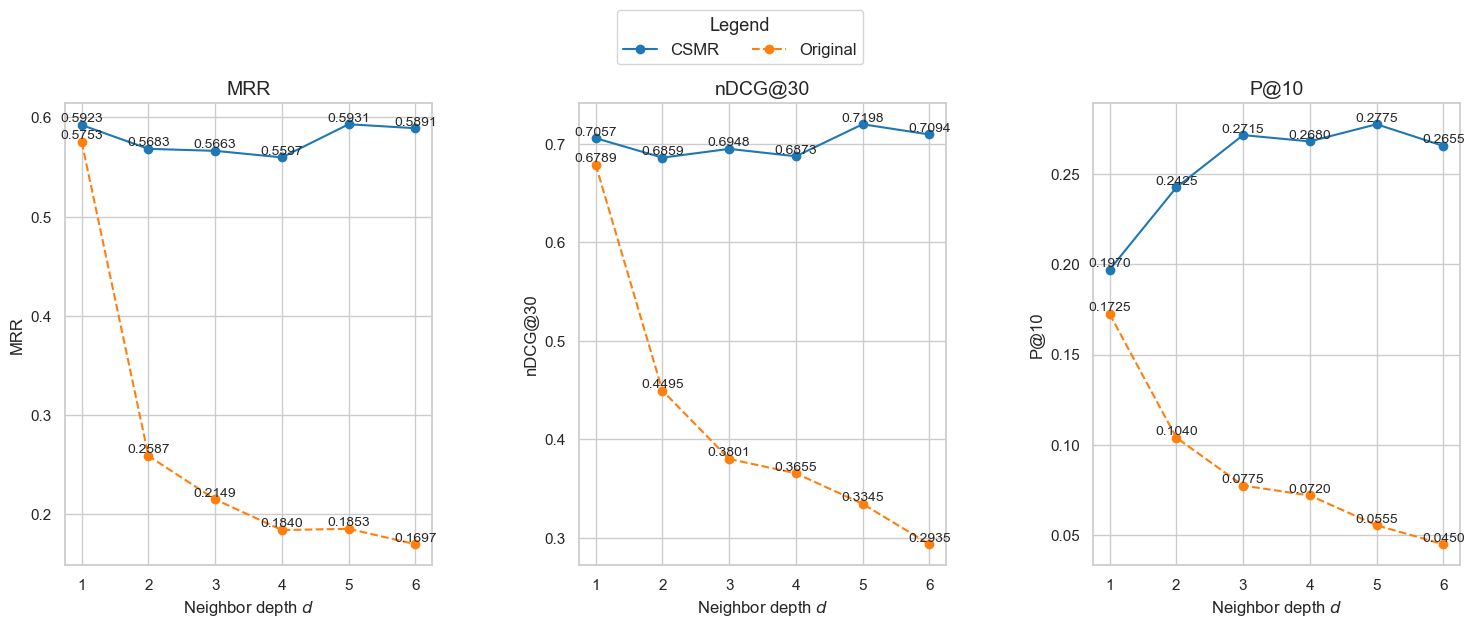

In [79]:
import matplotlib.pyplot as plt

# Data for each metric including values for d=1 to d=6
d_values = [1, 2, 3, 4, 5, 6]
metrics_data = {
    "MRR": {
        "sorted": [0.5923, 0.5683, 0.5663, 0.5597, 0.5931, 0.5891],
        "unsorted": [0.5753, 0.2587, 0.2149, 0.1840, 0.1853, 0.1697]
    },
    "nDCG@30": {
        "sorted": [0.7057, 0.6859, 0.6948, 0.6873, 0.7198, 0.7094],
        "unsorted": [0.6789, 0.4495, 0.3801, 0.3655, 0.3345, 0.2935]
    },
    "P@10": {
        "sorted": [0.1970, 0.2425, 0.2715, 0.2680, 0.2775, 0.2655],
        "unsorted": [0.1725, 0.1040, 0.0775, 0.0720, 0.0555, 0.0450]
    }
}

# Colors for lines
sorted_color = '#1f77b4'  # Blue
unsorted_color = '#ff7f0e'  # Orange

# Create a figure with a 1x3 grid for the plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.subplots_adjust(hspace=0.3, wspace=0.4)

# Plot each metric in a subplot
for ax, (metric, values) in zip(axes, metrics_data.items()):
    ax.plot(d_values, values["sorted"], marker='o', color=sorted_color, label="CSMR", linestyle="-")
    ax.plot(d_values, values["unsorted"], marker='o', color=unsorted_color, label="Original", linestyle="--")
    ax.set_title(f"{metric}", fontsize=14)
    ax.set_xlabel(r"Neighbor depth $\mathit{d}$", fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    ax.grid(True)
    
    # Add labels to each point
    for i, d in enumerate(d_values):
        ax.text(d, values["sorted"][i], f"{values['sorted'][i]:.4f}", ha="center", va="bottom", fontsize=10)
        ax.text(d, values["unsorted"][i], f"{values['unsorted'][i]:.4f}", ha="center", va="bottom", fontsize=10)

# Add a shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, fontsize=12, title="Legend", title_fontsize=13, bbox_to_anchor=(0.5, 1.05))

plt.show()


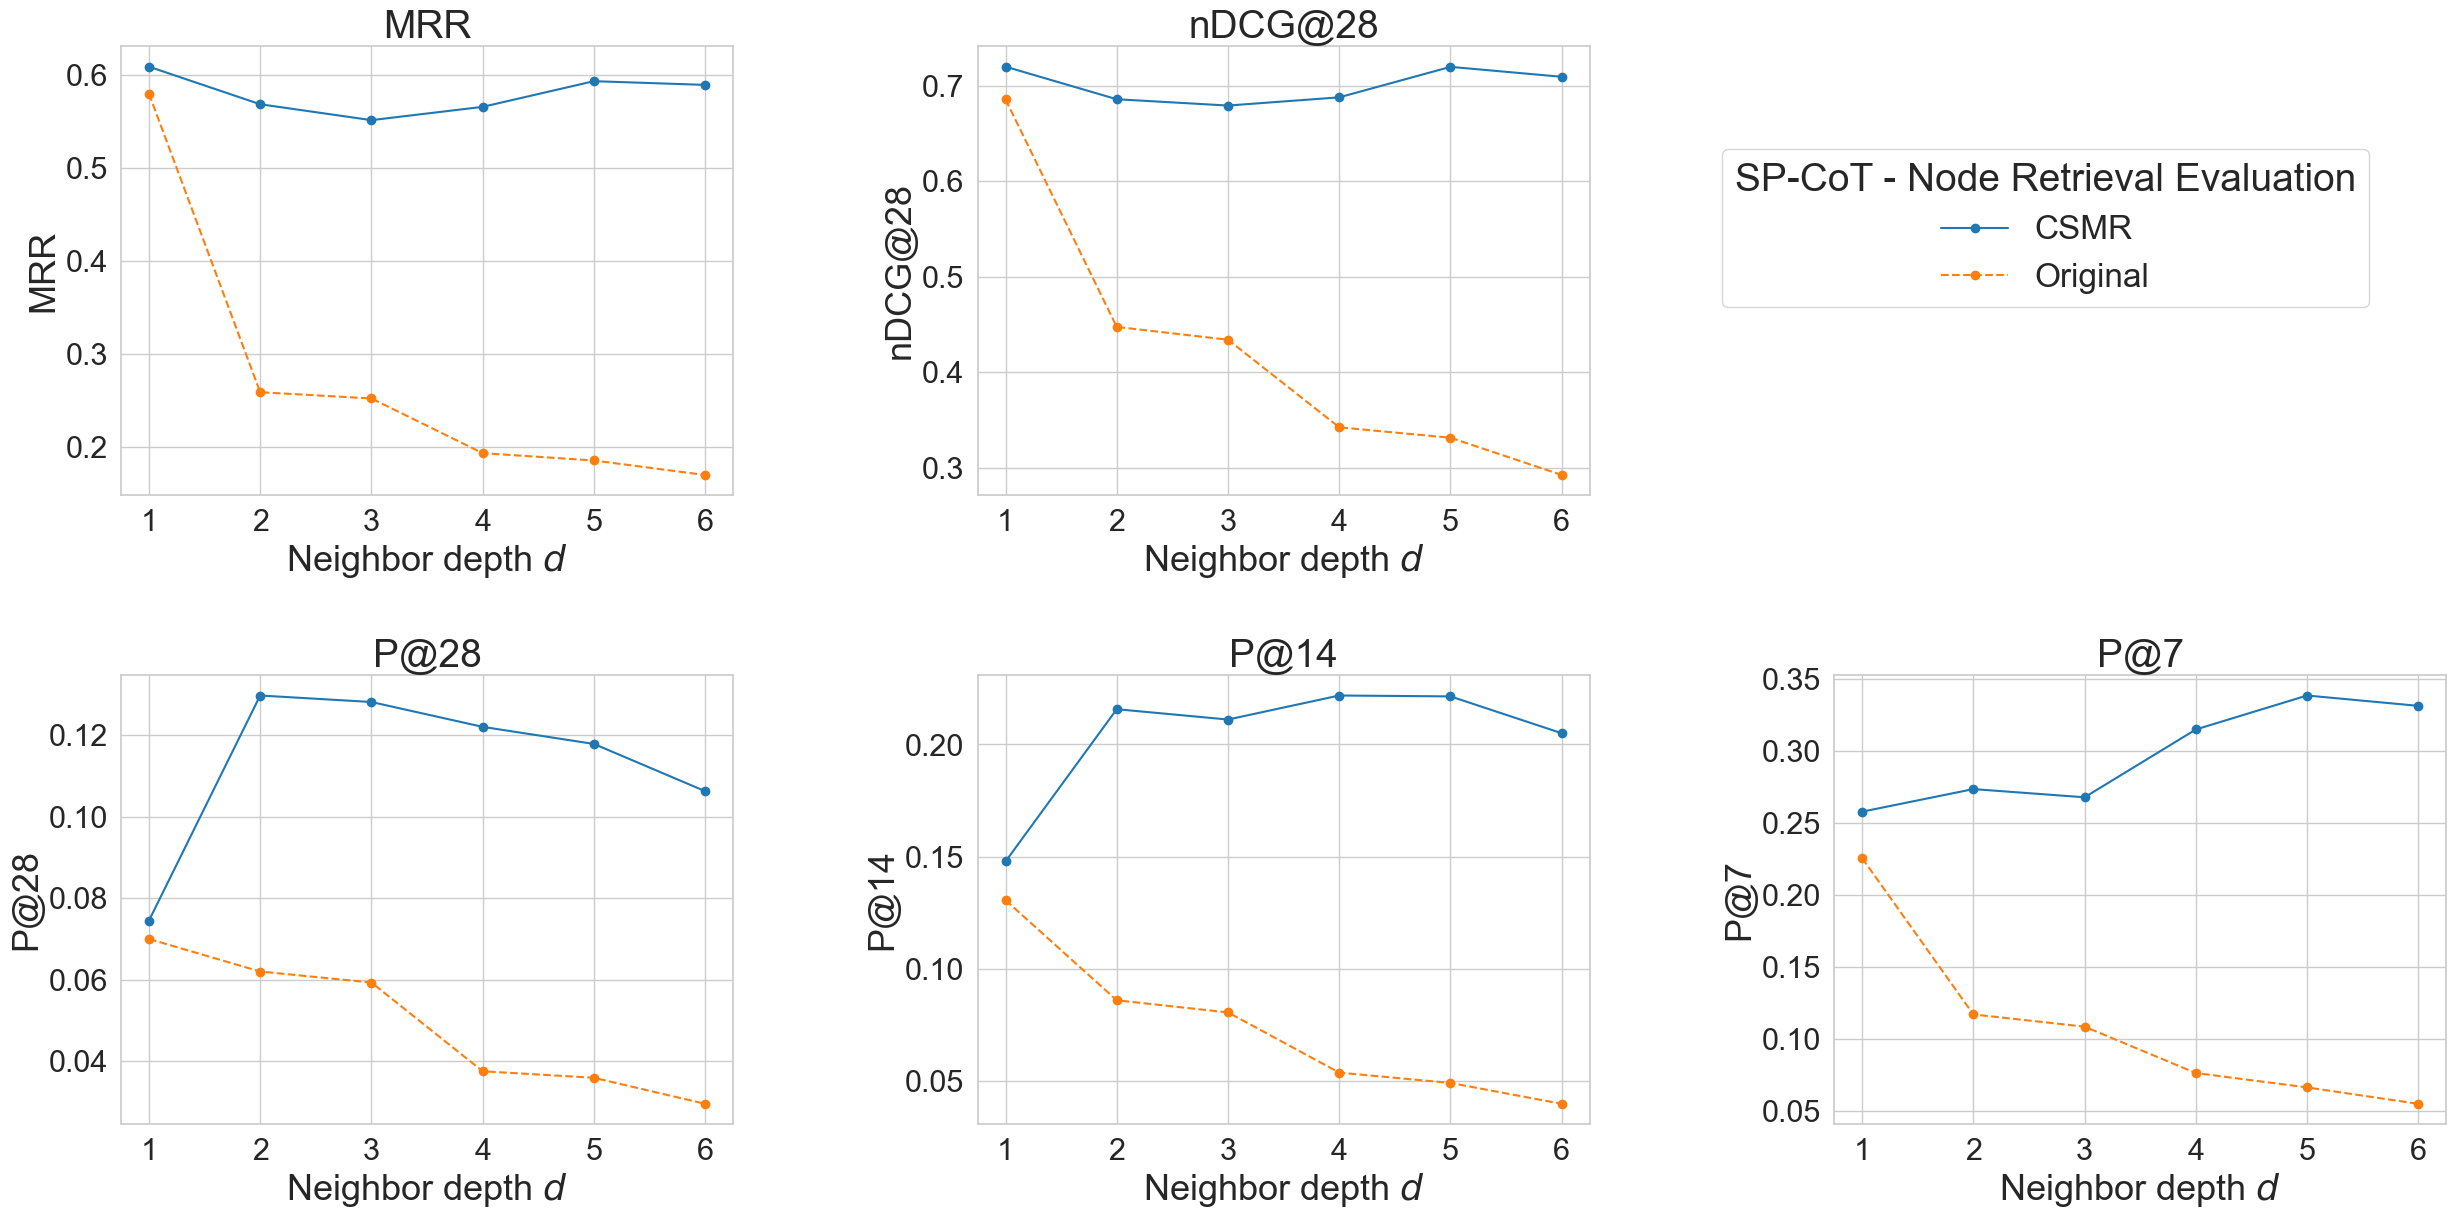

In [333]:
import matplotlib.pyplot as plt

# Data for each metric including values for d=1 to d=6
d_values = [1, 2, 3, 4, 5, 6]
metrics_data = {
    "MRR": {
        "sorted": [0.6087, 0.5683, 0.5512, 0.5655, 0.5931, 0.5891],
        "unsorted": [0.5797, 0.2587, 0.2520, 0.1932, 0.1853, 0.1697]
    },
    "nDCG@28": {
        "sorted": [0.7200, 0.6859, 0.6793, 0.6879, 0.7198, 0.7094],
        "unsorted": [0.6857, 0.4476, 0.4342, 0.3425, 0.3316, 0.2926]
    },
    "P@28": {
        "sorted": [0.0745, 0.1298, 0.1282, 0.1221, 0.1179, 0.1063],
        "unsorted": [0.0700, 0.0620, 0.0593, 0.0375, 0.0359, 0.0295]
    },
    "P@14": {
        "sorted": [0.1479, 0.2157, 0.2111, 0.2218, 0.2214, 0.2050],
        "unsorted": [0.1307, 0.0861, 0.0807, 0.0539, 0.0493, 0.0400]
    },
    "P@7": {
        "sorted": [0.2579, 0.2736, 0.2679, 0.3150, 0.3386, 0.3314],
        "unsorted": [0.2257, 0.1171, 0.1086, 0.0764, 0.0664, 0.0550]
    }
}

# Colors for lines
sorted_color = '#1f77b4'  # Blue
unsorted_color = '#ff7f0e'  # Orange

# Update global font size
plt.rcParams.update({
    'font.size': 22,
    'axes.titlesize': 28,
    'axes.labelsize': 26,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'legend.fontsize': 24,
    'legend.title_fontsize': 28
})

# Create a figure with a 2x3 grid for the plots
fig, axes = plt.subplots(2, 3, figsize=(30, 14))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Assign specific axes for each metric
mrr_ax = axes[0, 0]
ndcg_ax = axes[0, 1]
p28_ax = axes[1, 0]
p14_ax = axes[1, 1]
p7_ax = axes[1, 2]

# Define metrics and their corresponding axes
metric_axes = {
    "MRR": mrr_ax,
    "nDCG@28": ndcg_ax,
    "P@28": p28_ax,
    "P@14": p14_ax,
    "P@7": p7_ax
}

# Plot each metric in its assigned subplot
for metric, ax in metric_axes.items():
    values = metrics_data[metric]
    ax.plot(d_values, values["sorted"], marker='o', color=sorted_color, label="CSMR", linestyle="-")
    ax.plot(d_values, values["unsorted"], marker='o', color=unsorted_color, label="Original", linestyle="--")
    ax.set_title(f"{metric}", fontsize=28)
    ax.set_xlabel(r"Neighbor depth $\mathit{d}$", fontsize=26)
    ax.set_ylabel(metric, fontsize=26)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=22)

# Add a shared legend in the empty upper-right subplot space
handles, labels = mrr_ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="center right", ncol=1, fontsize=24, title="SP-CoT - Node Retrieval Evaluation", title_fontsize=28, bbox_to_anchor=(0.88, 0.75))

# Hide the empty subplot in the top right (axes[0, 2])
fig.delaxes(axes[0, 2])

plt.show()


In [324]:
metrics_sorted = {
    'mrr': mrr_sorted_list,
    'ndcg': ndcg_sorted_list,
    'precision_at_28': precision_at_28_sorted_list,
    'precision_at_14': precision_at_14_sorted_list,
    'precision_at_7': precision_at_7_sorted_list
}

metrics_unsorted = {
    'mrr': mrr_unsorted_list,
    'ndcg': ndcg_unsorted_list,
    'precision_at_28': precision_at_28_unsorted_list,
    'precision_at_14': precision_at_14_unsorted_list,
    'precision_at_7': precision_at_7_unsorted_list
}

# Example: Saving to JSON for later use
import json

with open('metrics_sorted.json', 'w') as f:
    json.dump(metrics_sorted, f, indent=4)

with open('metrics_unsorted.json', 'w') as f:
    json.dump(metrics_unsorted, f, indent=4)

print("\nPer-entry metrics have been saved to 'metrics_sorted.json' and 'metrics_unsorted.json'.")


Per-entry metrics have been saved to 'metrics_sorted.json' and 'metrics_unsorted.json'.


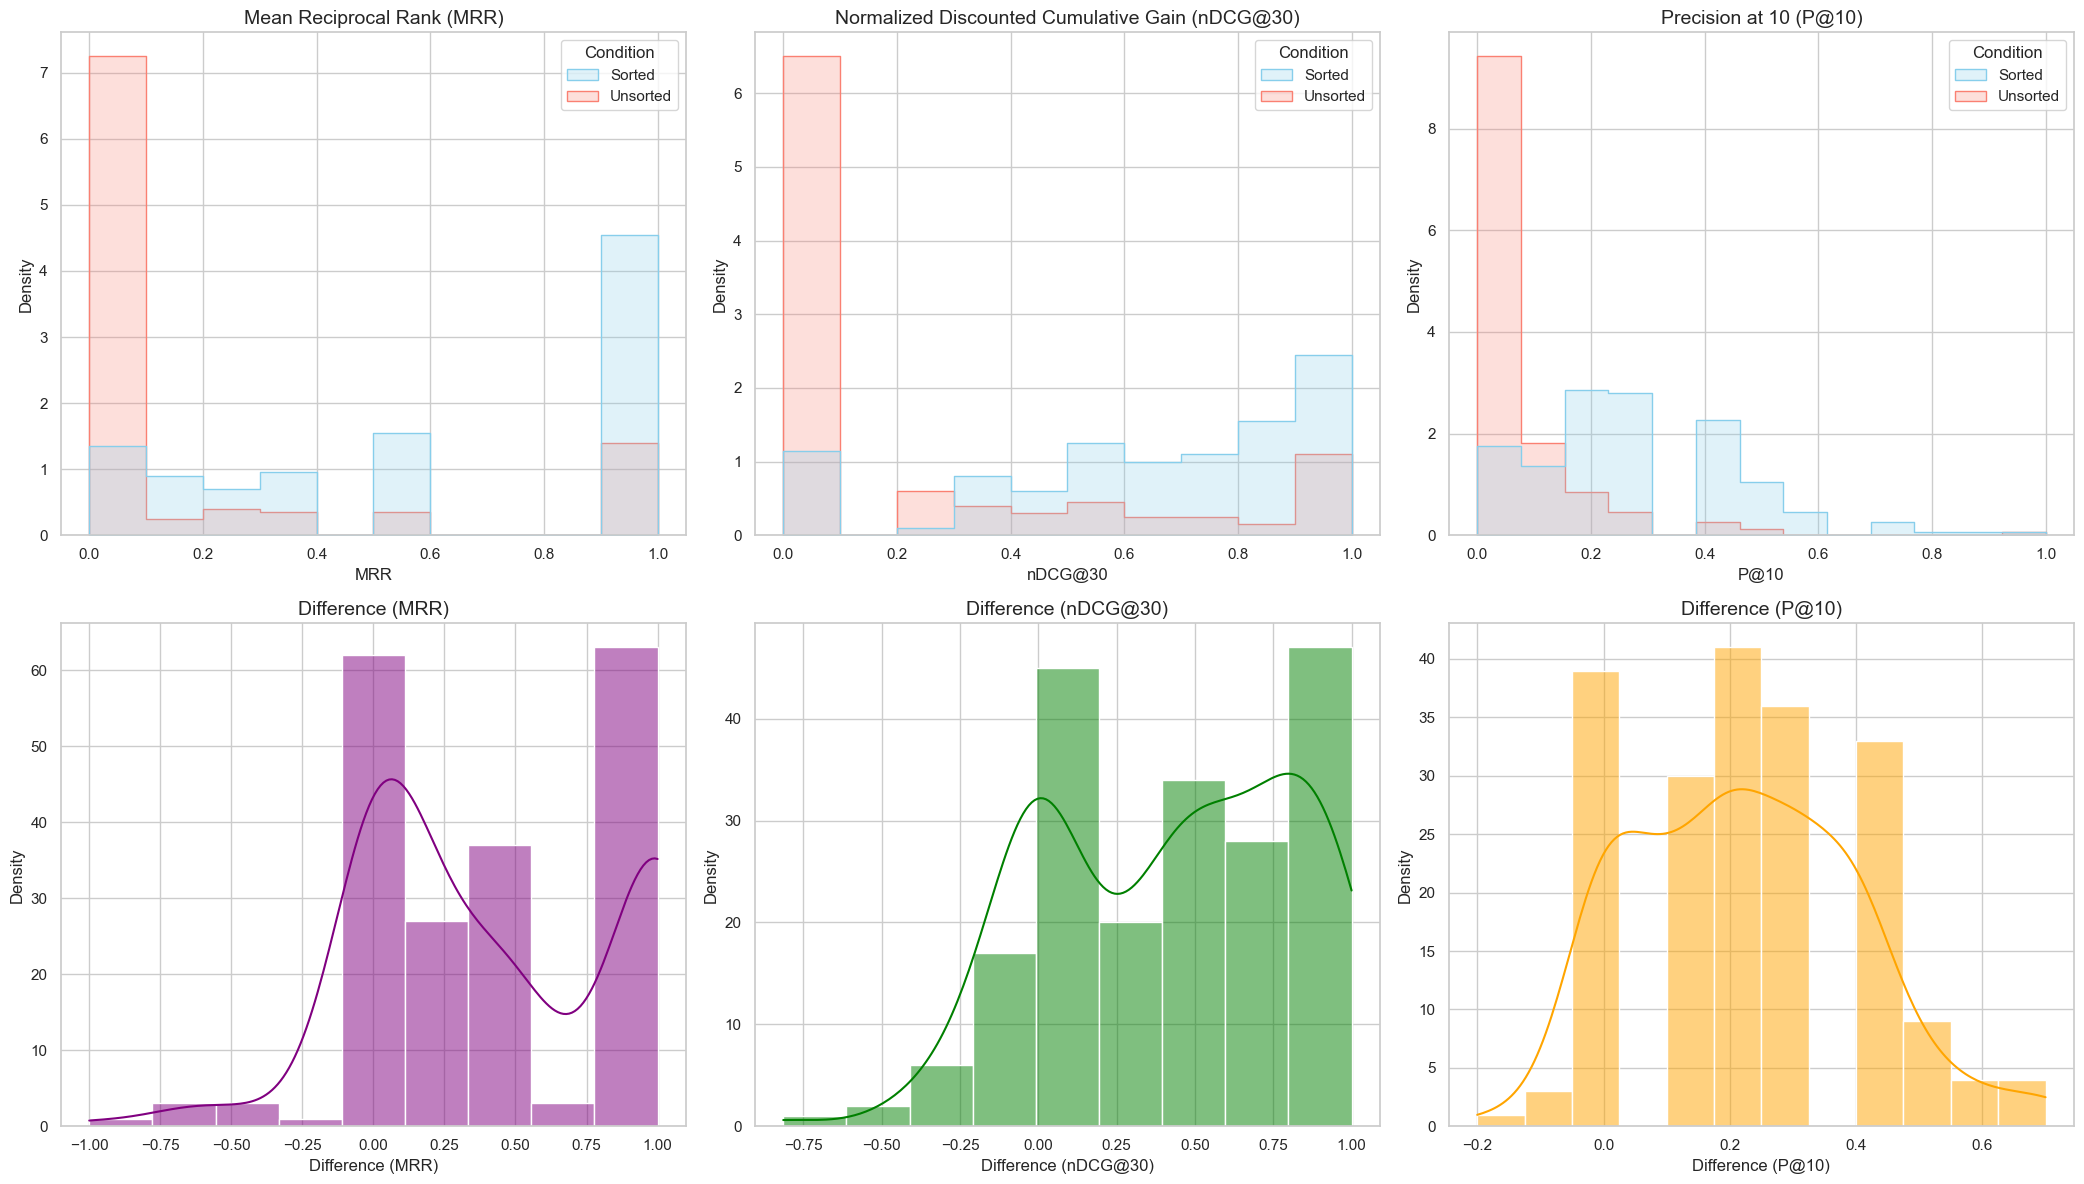

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming metrics_sorted and metrics_unsorted are dictionaries containing the per-query metrics
# Create DataFrames for each metric
df_mrr = pd.DataFrame({
    'Condition': ['Sorted'] * len(metrics_sorted['mrr']) + ['Unsorted'] * len(metrics_unsorted['mrr']),
    'MRR': metrics_sorted['mrr'] + metrics_unsorted['mrr']
})

df_ndcg = pd.DataFrame({
    'Condition': ['Sorted'] * len(metrics_sorted['ndcg']) + ['Unsorted'] * len(metrics_unsorted['ndcg']),
    'nDCG@30': metrics_sorted['ndcg'] + metrics_unsorted['ndcg']
})

df_p_at_k = pd.DataFrame({
    'Condition': ['Sorted'] * len(metrics_sorted['precision_at_10']) + ['Unsorted'] * len(metrics_unsorted['precision_at_10']),
    'P@10': metrics_sorted['precision_at_10'] + metrics_unsorted['precision_at_10']
})

# Create DataFrames for differences between sorted and unsorted for each metric
df_diff_mrr = pd.DataFrame({
    'Difference (MRR)': [sorted_val - unsorted_val for sorted_val, unsorted_val in zip(metrics_sorted['mrr'], metrics_unsorted['mrr'])]
})

df_diff_ndcg = pd.DataFrame({
    'Difference (nDCG@30)': [sorted_val - unsorted_val for sorted_val, unsorted_val in zip(metrics_sorted['ndcg'], metrics_unsorted['ndcg'])]
})

df_diff_p_at_k = pd.DataFrame({
    'Difference (P@10)': [sorted_val - unsorted_val for sorted_val, unsorted_val in zip(metrics_sorted['precision_at_10'], metrics_unsorted['precision_at_10'])]
})

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Initialize the matplotlib figure with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(21, 12))

# Define a color palette
palette = {"Sorted": "skyblue", "Unsorted": "salmon"}

# Plot MRR Histogram
sns.histplot(data=df_mrr, x='MRR', hue='Condition', element='step', stat='density',
             common_norm=False, palette=palette, ax=axes[0, 0])
axes[0, 0].set_title('Mean Reciprocal Rank (MRR)', fontsize=14)
axes[0, 0].set_xlabel('MRR', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)

# Plot nDCG@30 Histogram
sns.histplot(data=df_ndcg, x='nDCG@30', hue='Condition', element='step', stat='density',
             common_norm=False, palette=palette, ax=axes[0, 1])
axes[0, 1].set_title('Normalized Discounted Cumulative Gain (nDCG@30)', fontsize=14)
axes[0, 1].set_xlabel('nDCG@30', fontsize=12)
axes[0, 1].set_ylabel('Density', fontsize=12)

# Plot Precision@10 Histogram
sns.histplot(data=df_p_at_k, x='P@10', hue='Condition', element='step', stat='density',
             common_norm=False, palette=palette, ax=axes[0, 2])
axes[0, 2].set_title('Precision at 10 (P@10)', fontsize=14)
axes[0, 2].set_xlabel('P@10', fontsize=12)
axes[0, 2].set_ylabel('Density', fontsize=12)

# Plot Differences MRR
sns.histplot(data=df_diff_mrr, x='Difference (MRR)', kde=True, color="purple", ax=axes[1, 0])
axes[1, 0].set_title('Difference (MRR)', fontsize=14)
axes[1, 0].set_xlabel('Difference (MRR)', fontsize=12)
axes[1, 0].set_ylabel('Density', fontsize=12)

# Plot Differences nDCG@30
sns.histplot(data=df_diff_ndcg, x='Difference (nDCG@30)', kde=True, color="green", ax=axes[1, 1])
axes[1, 1].set_title('Difference (nDCG@30)', fontsize=14)
axes[1, 1].set_xlabel('Difference (nDCG@30)', fontsize=12)
axes[1, 1].set_ylabel('Density', fontsize=12)

# Plot Differences P@10
sns.histplot(data=df_diff_p_at_k, x='Difference (P@10)', kde=True, color="orange", ax=axes[1, 2])
axes[1, 2].set_title('Difference (P@10)', fontsize=14)
axes[1, 2].set_xlabel('Difference (P@10)', fontsize=12)
axes[1, 2].set_ylabel('Density', fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()


Shapiro-Wilk test for MRR differences: p-value = 0.0000
Shapiro-Wilk test for nDCG@28 differences: p-value = 0.0000
Shapiro-Wilk test for P@28 differences: p-value = 0.0000
Shapiro-Wilk test for P@14 differences: p-value = 0.0001
Shapiro-Wilk test for P@7 differences: p-value = 0.0000


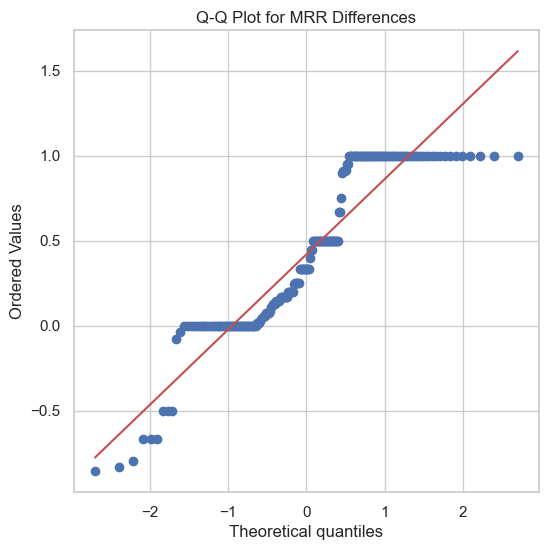

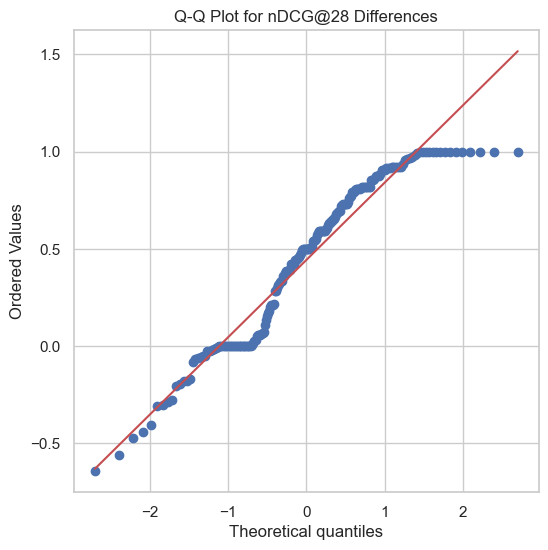

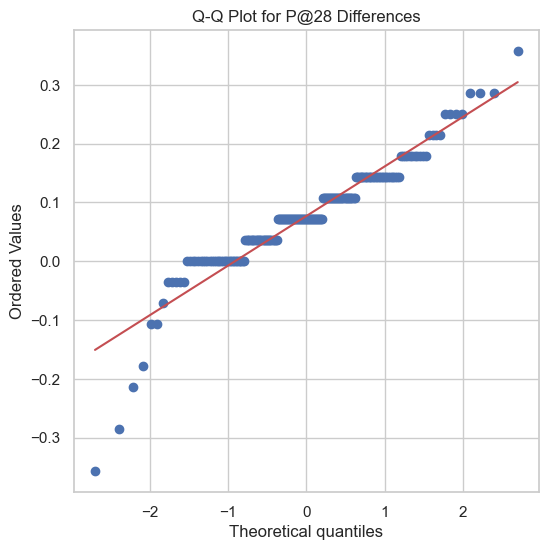

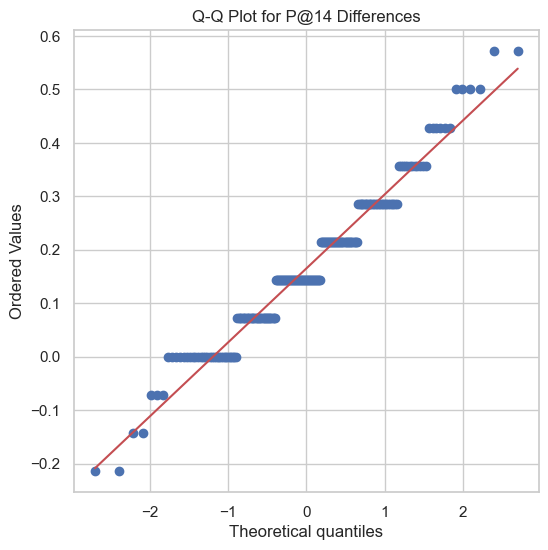

Text(0.5, 1.0, 'Q-Q Plot for P@7 Differences')

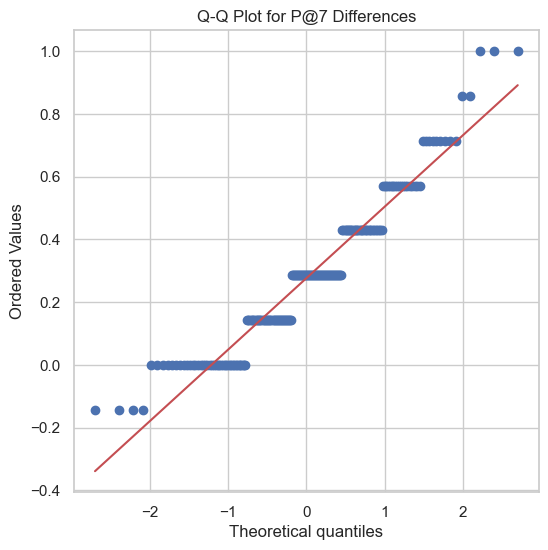

In [325]:
import scipy.stats as stats
import matplotlib.pyplot as plt

# Calculate differences for each metric
differences_mrr = [sorted_val - unsorted_val for sorted_val, unsorted_val in zip(metrics_sorted['mrr'], metrics_unsorted['mrr'])]
differences_ndcg = [sorted_val - unsorted_val for sorted_val, unsorted_val in zip(metrics_sorted['ndcg'], metrics_unsorted['ndcg'])]
differences_p_at_28 = [sorted_val - unsorted_val for sorted_val, unsorted_val in zip(metrics_sorted['precision_at_28'], metrics_unsorted['precision_at_28'])]
differences_p_at_14 = [sorted_val - unsorted_val for sorted_val, unsorted_val in zip(metrics_sorted['precision_at_14'], metrics_unsorted['precision_at_14'])]
differences_p_at_7 = [sorted_val - unsorted_val for sorted_val, unsorted_val in zip(metrics_sorted['precision_at_7'], metrics_unsorted['precision_at_7'])]

# Perform Shapiro-Wilk test for each metric
shapiro_mrr = stats.shapiro(differences_mrr)
shapiro_ndcg = stats.shapiro(differences_ndcg)
shapiro_p_at_28 = stats.shapiro(differences_p_at_28)
shapiro_p_at_14 = stats.shapiro(differences_p_at_14)
shapiro_p_at_7 = stats.shapiro(differences_p_at_7)

print(f"Shapiro-Wilk test for MRR differences: p-value = {shapiro_mrr.pvalue:.4f}")
print(f"Shapiro-Wilk test for nDCG@28 differences: p-value = {shapiro_ndcg.pvalue:.4f}")
print(f"Shapiro-Wilk test for P@28 differences: p-value = {shapiro_p_at_28.pvalue:.4f}")
print(f"Shapiro-Wilk test for P@14 differences: p-value = {shapiro_p_at_14.pvalue:.4f}")
print(f"Shapiro-Wilk test for P@7 differences: p-value = {shapiro_p_at_7.pvalue:.4f}")


# Q-Q plot for MRR differences
plt.figure(figsize=(6, 6))
stats.probplot(differences_mrr, dist="norm", plot=plt)
plt.title("Q-Q Plot for MRR Differences")
plt.show()

# Q-Q plot for nDCG@28 differences
plt.figure(figsize=(6, 6))
stats.probplot(differences_ndcg, dist="norm", plot=plt)
plt.title("Q-Q Plot for nDCG@28 Differences")
plt.show()

# Q-Q plot for P@28 differences
plt.figure(figsize=(6, 6))
stats.probplot(differences_p_at_28, dist="norm", plot=plt)
plt.title("Q-Q Plot for P@28 Differences")
plt.show()

# Q-Q plot for P@14 differences
plt.figure(figsize=(6, 6))
stats.probplot(differences_p_at_14, dist="norm", plot=plt)
plt.title("Q-Q Plot for P@14 Differences")
plt.show()

# Q-Q plot for P@7 differences
plt.figure(figsize=(6, 6))
stats.probplot(differences_p_at_7, dist="norm", plot=plt)
plt.title("Q-Q Plot for P@7 Differences")

# d1
# Paired t-test Results:
# MRR: t-statistic = 0.9974, p-value = 3.1980e-01
# nDCG@30: t-statistic = 2.6132, p-value = 9.6552e-03
# P@10: t-statistic = 3.6739, p-value = 3.0705e-04


# Paired t-test Results:
# MRR: t-statistic = 10.4245, p-value = 1.3979e-20
# nDCG@30: t-statistic = 13.1206, p-value = 9.5977e-29
# P@10: t-statistic = 11.1749, p-value = 8.0973e-23


# d3
# Paired t-test Results:
# MRR: t-statistic = 10.9558, p-value = 3.6769e-22
# nDCG@30: t-statistic = 13.6501, p-value = 2.2568e-30
# P@10: t-statistic = 12.9061, p-value = 4.3718e-28


# d4
# Paired t-test Results:
# MRR: t-statistic = 11.6745, p-value = 2.5138e-24
# nDCG@30: t-statistic = 14.6297, p-value = 2.1803e-33
# P@10: t-statistic = 14.5756, p-value = 3.1980e-33

In [284]:
# Perform Wilcoxon signed-rank test for each metric
wilcoxon_mrr = stats.wilcoxon(differences_mrr)
wilcoxon_ndcg = stats.wilcoxon(differences_ndcg)
wilcoxon_p_at_k = stats.wilcoxon(differences_p_at_k)

print(f"Wilcoxon test for MRR differences: p-value = {wilcoxon_mrr.pvalue}")
print(f"Wilcoxon test for nDCG differences: p-value = {wilcoxon_ndcg.pvalue}")
print(f"Wilcoxon test for P@10 differences: p-value = {wilcoxon_p_at_k.pvalue}")





# d = 1
# Wilcoxon test for MRR differences: p-value = 0.25776114270546147
# Wilcoxon test for nDCG differences: p-value = 0.009598717670005258
# Wilcoxon test for P@10 differences: p-value = 5.519590807408112e-05


#d = 2
# Wilcoxon test for MRR differences: p-value = 2.3008233907792485e-20
# Wilcoxon test for nDCG differences: p-value = 7.517623405519623e-25
# Wilcoxon test for P@10 differences: p-value = 7.057605378057151e-20

# d = 3
# Wilcoxon test for MRR differences: p-value = 1.9948464223596646e-20
# Wilcoxon test for nDCG differences: p-value = 2.1420120757006535e-23
# Wilcoxon test for P@10 differences: p-value = 9.392735037703501e-24

# d = 4
# Wilcoxon test for MRR differences: p-value = 2.522620607031843e-21
# Wilcoxon test for nDCG differences: p-value = 1.8544844276013673e-24
# Wilcoxon test for P@10 differences: p-value = 1.9503554770175597e-23

# d = 5
# Wilcoxon test for MRR differences: p-value = 1.3553238960239724e-21
# Wilcoxon test for nDCG differences: p-value = 2.2546454406827187e-24
# Wilcoxon test for P@10 differences: p-value = 1.758440646133195e-27





Wilcoxon test for MRR differences: p-value = 7.967272959796052e-20
Wilcoxon test for nDCG differences: p-value = 1.0986662154608753e-23
Wilcoxon test for P@10 differences: p-value = 1.758440646133195e-27


In [1]:
!pip install statsmodels

  Using cached statsmodels-0.14.4-cp311-cp311-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached patsy-0.5.6-py2.py3-none-any.whl.metadata (3.5 kB)
Using cached statsmodels-0.14.4-cp311-cp311-macosx_11_0_arm64.whl (9.9 MB)
Using cached patsy-0.5.6-py2.py3-none-any.whl (233 kB)


In [326]:
from statsmodels.stats.descriptivestats import sign_test

# Perform Sign test for each metric
sign_test_mrr = sign_test(differences_mrr, mu0=0)
sign_test_ndcg = sign_test(differences_ndcg, mu0=0)
sign_test_p_at_28 = sign_test(differences_p_at_28, mu0=0)
sign_test_p_at_14 = sign_test(differences_p_at_14, mu0=0)
sign_test_p_at_7 = sign_test(differences_p_at_7, mu0=0)

# Print the results
print(f"Sign test for MRR differences: Test Statistic = {sign_test_mrr[0]:.4f}, p-value = {sign_test_mrr[1]:.4e}")
print(f"Sign test for nDCG@28 differences: Test Statistic = {sign_test_ndcg[0]:.4f}, p-value = {sign_test_ndcg[1]:.4e}")
print(f"Sign test for P@28 differences: Test Statistic = {sign_test_p_at_28[0]:.4f}, p-value = {sign_test_p_at_28[1]:.4e}")
print(f"Sign test for P@14 differences: Test Statistic = {sign_test_p_at_14[0]:.4f}, p-value = {sign_test_p_at_14[1]:.4e}")
print(f"Sign test for P@7 differences: Test Statistic = {sign_test_p_at_7[0]:.4f}, p-value = {sign_test_p_at_7[1]:.4e}")


# d = 1
# Sign test for MRR differences: Test Statistic = 9.0000, p-value = 1.5347e-02
# Sign test for nDCG@28 differences: Test Statistic = 14.5000, p-value = 1.2632e-03
# Sign test for P@28 differences: Test Statistic = 6.0000, p-value = 4.2774e-02
# Sign test for P@14 differences: Test Statistic = 10.0000, p-value = 8.2140e-04
# Sign test for P@7 differences: Test Statistic = 10.5000, p-value = 1.9220e-04

# d = 2
# Sign test for MRR differences: Test Statistic = 61.5000, p-value = 1.8644e-30
# Sign test for nDCG@28 differences: Test Statistic = 67.0000, p-value = 4.5017e-26
# Sign test for P@28 differences: Test Statistic = 62.0000, p-value = 8.4625e-27
# Sign test for P@14 differences: Test Statistic = 67.0000, p-value = 1.5748e-33
# Sign test for P@7 differences: Test Statistic = 49.5000, p-value = 7.9529e-24

# d = 3
# Sign test for MRR differences: Test Statistic = 61.0000, p-value = 3.5397e-30
# Sign test for nDCG@28 differences: Test Statistic = 69.0000, p-value = 4.6941e-29
# Sign test for P@28 differences: Test Statistic = 61.5000, p-value = 1.5378e-26
# Sign test for P@14 differences: Test Statistic = 64.0000, p-value = 3.5814e-31
# Sign test for P@7 differences: Test Statistic = 50.0000, p-value = 4.8957e-27

# d = 4
# Sign test for MRR differences: Test Statistic = 66.0000, p-value = 6.7033e-30
# Sign test for nDCG@28 differences: Test Statistic = 63.0000, p-value = 7.4011e-23
# Sign test for P@28 differences: Test Statistic = 73.5000, p-value = 6.3477e-34
# Sign test for P@14 differences: Test Statistic = 76.0000, p-value = 7.4721e-38
# Sign test for P@7 differences: Test Statistic = 67.5000, p-value = 1.8594e-32

# d = 5
# Sign test for MRR differences: Test Statistic = 65.0000, p-value = 1.7629e-30
# Sign test for nDCG@28 differences: Test Statistic = 60.5000, p-value = 1.0722e-21
# Sign test for P@28 differences: Test Statistic = 69.0000, p-value = 5.6974e-30
# Sign test for P@14 differences: Test Statistic = 74.0000, p-value = 4.7942e-36
# Sign test for P@7 differences: Test Statistic = 72.0000, p-value = 7.6929e-39

# d = 6
# Sign test for MRR differences: Test Statistic = 68.5000, p-value = 8.5284e-32
# Sign test for nDCG@28 differences: Test Statistic = 63.0000, p-value = 7.4011e-23
# Sign test for P@28 differences: Test Statistic = 72.5000, p-value = 2.1965e-33
# Sign test for P@14 differences: Test Statistic = 78.0000, p-value = 1.0026e-39
# Sign test for P@7 differences: Test Statistic = 76.0000, p-value = 3.6917e-41








Sign test for MRR differences: Test Statistic = 68.5000, p-value = 8.5284e-32
Sign test for nDCG@28 differences: Test Statistic = 63.0000, p-value = 7.4011e-23
Sign test for P@28 differences: Test Statistic = 72.5000, p-value = 2.1965e-33
Sign test for P@14 differences: Test Statistic = 78.0000, p-value = 1.0026e-39
Sign test for P@7 differences: Test Statistic = 76.0000, p-value = 3.6917e-41
